# splitting cdc subsetted data into stages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


# splitting data into cdc subset

In [3]:
keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')

there are a total of 53272 tweets after subsetting for cdc keywords


# finding 4 stages

(49, 88, 112, 1.0715076876466606e-05, -0.001215763823993183, -1.1384012969242378e-07, 0.0026055594087748624, 0.0038321521497742045)
splits are at 2020-03-12, 2020-04-20, 2020-05-14


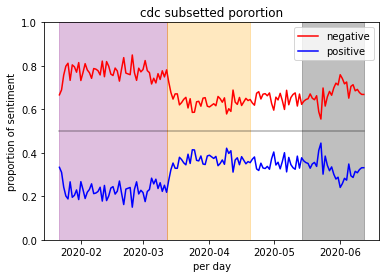

In [9]:
x_y_dict = {x:y for x,y in enumerate(cdc.groupby(['date']).agg({'is_negative':'mean'})['is_negative'])}
date2i = {i:date for i,date in enumerate(cdc.groupby(['date']).agg({'is_negative':'mean'}).index)}
X = [x for x in x_y_dict]
Y = [x_y_dict[x] for x in x_y_dict]

def best_fit(X, Y):
    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return b
# import math as m
keep = None

for a in range(3, len(X)-2): # 3 to 139
    for b in range(4, len(X)-3):
        for c in range(4, len(X)-3):
            if a < b and b - a > 3 and c - b > 3: # splits are concurrent and the middle section is at least 3
                X1, X2, X3, X4 = X[0:a], X[a:b], X[b:c], X[c:]
                Y1, Y2, Y3, Y4 = Y[0:a], Y[a:b], Y[b:c], Y[c:]
                if len(X1) > 3 and len(X2) > 3 and len(X3) > 3 and len(X4) > 3: # min length of stages?
                    s1, s2, s3, s4 = best_fit(X1, Y1), best_fit(X2, Y2), best_fit(X3, Y3), best_fit(X4, Y4)
                    ss = abs(s1) + abs(s2) + abs(s3) + abs(s4)
                    # if sum of slopes is closer to 0, then keep
                    if keep is None:
                        keep = (a, b, c, s1, s2, s3, s4, ss)
                    # elif abs(s1) < abs(keep[3]) and s2 < keep[4] and abs(s3) < abs(keep[5]) and s4 - keep[6] > 0:
                    # elif s2 - keep[6] < 0 and s4 - keep[6] > 0:
                    elif abs(s1) + abs(s3) < abs(keep[3]) + abs(keep[5]):
                        keep = (a, b, c, s1, s2, s3, s4, ss)
                

print(keep)
print(f'splits are at {date2i[keep[0]]}, {date2i[keep[1]]}, {date2i[keep[2]]}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4)) #sharey = True

ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
ndf['nnegative'] = ndf['count'] * ndf['is_negative']
ndf['npositive'] = ndf['count'] - ndf['nnegative']
ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

splits = [date2i[keep[0]], date2i[keep[1]], date2i[keep[2]]]
colors = ['purple', 'orange', 'black']
# print(min_date)

ax.plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax.plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(splits):
    if i == 0:
        ax.axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(splits)-1:
        ax.axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(splits)-1:
        ax.axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax.set_ylabel('proportion of sentiment')
ax.set_xlabel('per day')
ax.set_title(f'cdc subsetted porortion')
ax.set_ylim(0,1)
ax.legend()
plt.show()

# cdc subset Ngram

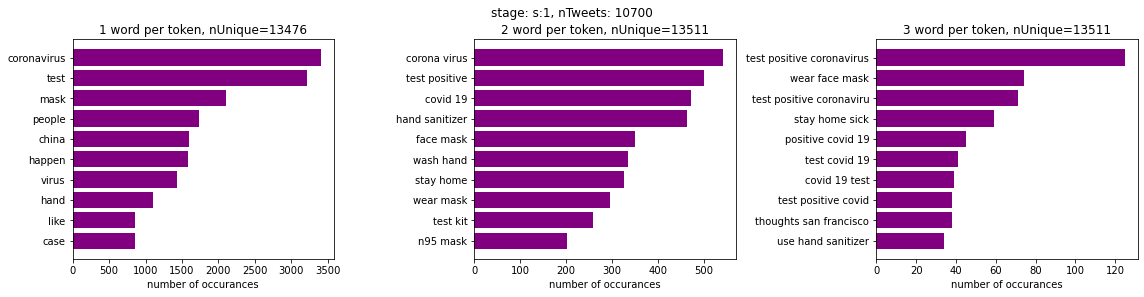

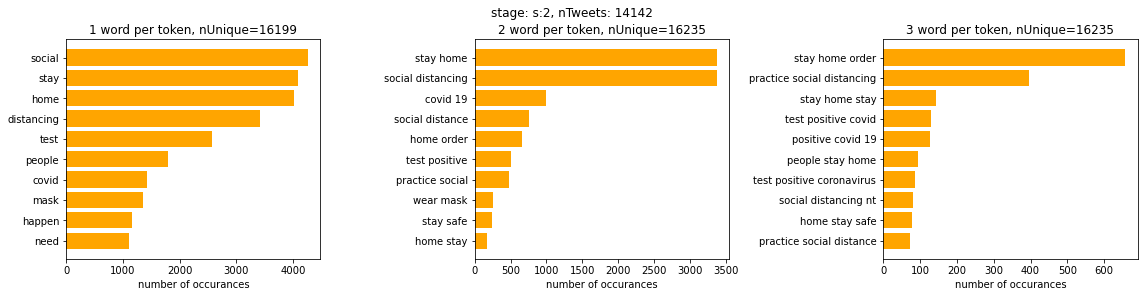

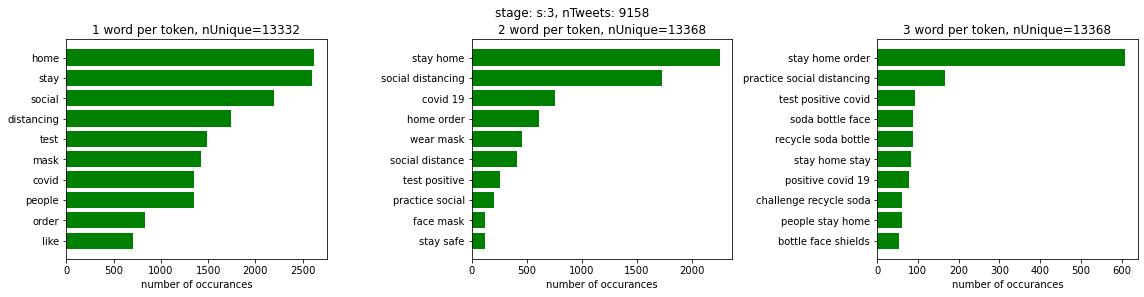

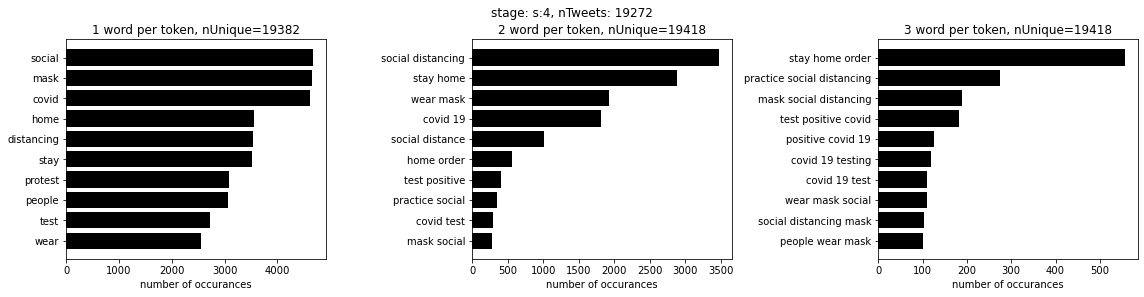

In [7]:
splits = pd.to_datetime(['2020-03-12', '2020-04-20', '2020-05-14'])
cdc['stage'] = ['s:1' if date < splits[0] else 's:2' if date < splits[1] else 's:3' if date < splits[2] else 's:4' for date in cdc['date']]

def get_Nwords(corpus, n=None, Nwords=1):
    vec1 = CountVectorizer(ngram_range=(Nwords,Nwords),  
            max_features=n).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [{'token':word, 'n':sum_words[0, idx]} for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x['n'], 
                reverse=True)
    return pd.DataFrame(words_freq)

colors = ['purple', 'orange', 'green', 'black']

exclude = ['19', 'nt', 'amp', 'gon na', 'wo nt', 'corona virus nt', 'ai nt']
# exclude = ['']

for k, (stage, df) in enumerate(cdc.groupby(['stage'])):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True
    for i, Nwords in enumerate([1, 2, 3]):

        corpus = [text for text in df['cleantext']]
        max_words = len({word:1 for text in corpus for word in text.split(' ')})
        top_df = get_Nwords(corpus, n=max_words, Nwords=Nwords)
        n = len(top_df.index)
        top_df['prop'] = round(top_df['n']/top_df['n'].sum(),4)
        top_df = top_df[~top_df['token'].isin(exclude)]
        top_df = top_df.head(10).sort_values(by='n', ascending=True)
        # print(stage, top_df.shape)
        # print(top_df.head(10))
        ax[i].barh(y=top_df['token'], width=top_df['n'], color=colors[k])
        ax[i].set_title(f'{Nwords} word per token, nUnique={n}')
        ax[i].set_xlabel('number of occurances')
    fig.suptitle(f'stage: {stage}, nTweets: {len(df.index)}', y=1.02)
    plt.tight_layout()
    plt.show()

# cdc subset tweet is document

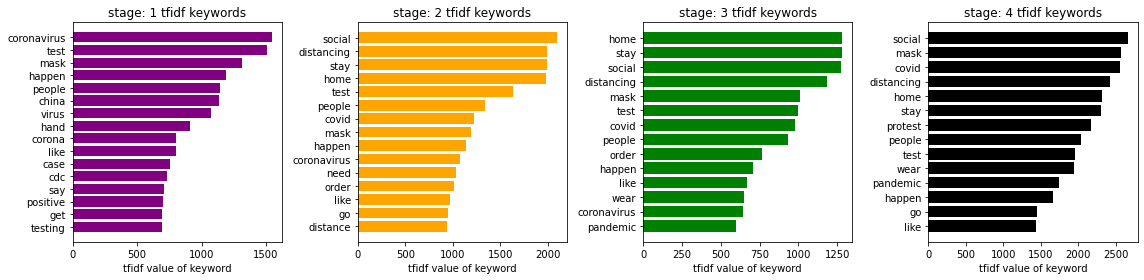

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4)) #sharey = True
colors = ['purple', 'orange', 'green', 'black']
exclude = ['m', 'nt', 's', '19', 'amp', 't', 'amp']
# exclude = ['']

for i in range(4):
    df = pd.read_csv(f'tfidf/cdc.split4.tfidf_s{i+1}.csv').sort_values(by='tfidf', ascending=False).head(20)
    df = df[~df['word'].isin(exclude)].sort_values(by='tfidf', ascending=True)
    ax[i].barh(y=df['word'].astype(str), width=df['tfidf'].astype(float), color=colors[i])
    ax[i].set_title(f'stage: {i+1} tfidf keywords')
    ax[i].set_xlabel('tfidf value of keyword')
plt.tight_layout()
plt.show()

# aggregated cdc subset to daily document

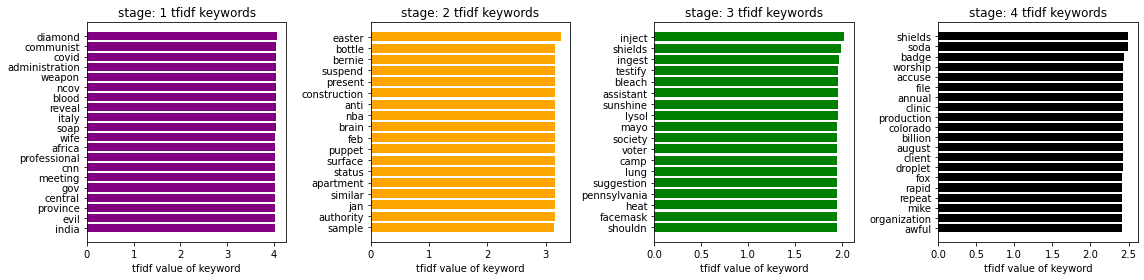

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4)) #sharey = True
colors = ['purple', 'orange', 'green', 'black']
exclude = ['uv', 'l', ' ', '_', 'lt']
# exclude = ['']

for i in range(4):
    df = pd.read_csv(f'tfidf/cdc.split4.agg.tfidf_s{i+1}.csv').sort_values(by='tfidf', ascending=False).head(20)
    df = df[~df['word'].isin(exclude)].sort_values(by='tfidf', ascending=True)
    ax[i].barh(y=df['word'].astype(str), width=df['tfidf'].astype(float), color=colors[i])
    ax[i].set_title(f'stage: {i+1} tfidf keywords')
    ax[i].set_xlabel('tfidf value of keyword')
plt.tight_layout()
plt.show()